## Visión por Computador

**Grupo 17**:

- Sara Expósito Suárez
- Alejandro Padrón Ossorio

Paquetes necesarios

In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



En la imagen hay 8 monedas que suman un total de 3.88€


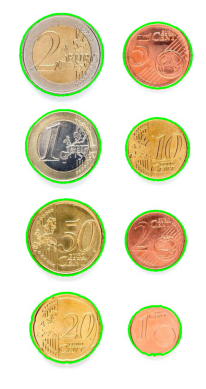

In [5]:
img = cv2.imread('Monedas2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
img_gris = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

img_ggris = cv2.GaussianBlur(img_gris, (7, 7), 0)

th,img_th = cv2.threshold(img_ggris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb, contornos, -1, (0, 255, 0), 3)

selected_radius = None

def select_coin(event, x, y, flags, param):
    global selected_radius
    if event == cv2.EVENT_LBUTTONDOWN:
        for c in contornos:
            (cx, cy), radio = cv2.minEnclosingCircle(c)
            if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                selected_radius = radio
                break

cv2.imshow("Selecciona la moneda de 1 euro", img)
cv2.setMouseCallback("Selecciona la moneda de 1 euro", select_coin)

while selected_radius is None:
    if cv2.waitKey(10) == 27:
        break

coins_diameter = [16.26, 18.75, 21.25, 19.75, 22.25, 24.25, 23.25, 25.75]
coins_value = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
coins_color = ["copper", "copper", "copper", "gold", "gold", "gold", "silver_gold", "silver_gold"]

if selected_radius:
    ratio = selected_radius * 2 / coins_diameter[6]

money_amount = 0
tolerance = 3

def get_avg_color(contornos, img_hsv):
    mask = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contornos, -1, 255, -1)
    mean_value = cv2.mean(img_hsv, mask=mask)
    return mean_value[:3]

def classify_color_hsv(avg_color):
    h, s, v = avg_color
    
    if 10 < h < 20 and s > 100:
        return "copper"
    elif 20 < h < 30 and s > 100:
        return "gold"
    
    return "silver_gold"

coins_count = 0

for c in contornos:
    area = cv2.contourArea(c)
    if area > 10:
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        coins_count += 1
    else:
        continue

    diameter = radio * 2
    detected = False
    
    avg_color = get_avg_color(c, img_hsv)
    color = classify_color_hsv(avg_color)
    
    for coin_diameter, coin_value, coin_color in zip(coins_diameter, coins_value, coins_color):
        if abs(diameter - ratio * coin_diameter) < tolerance:
            money_amount += coin_value
            detected = True
            break

    if not detected:
        money_amount += coins_value[-1]

print(f"En la imagen hay {coins_count} monedas que suman un total de {money_amount}€")
plt.imshow(img_rgb)
plt.axis("off")

cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

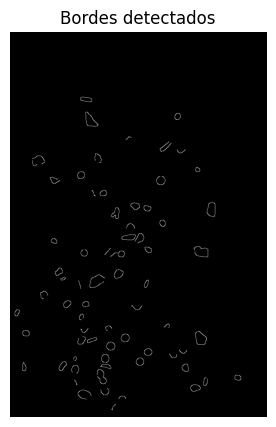

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en escala de grises
img_gris = cv2.imread('MPS.jpg', cv2.IMREAD_GRAYSCALE)

# Ecualización del histograma para mejorar el contraste
img_contraste = cv2.equalizeHist(img_gris)

# Suavizado Gaussiano para reducir ruido
img_contraste = cv2.GaussianBlur(img_contraste, (15, 15), 0)

# Detección de bordes para resaltar contornos
bordes = cv2.Canny(img_contraste, 100, 200)

# Mostrar imagen con bordes
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(bordes, cmap='gray')
plt.title('Bordes detectados')
plt.show()

Se encontraron 68 contornos.


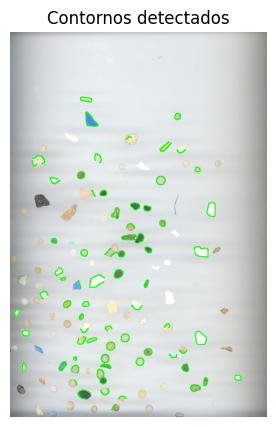

In [57]:
# Operación de cierre morfológico para mejorar el cierre de los contornos
kernel = np.ones((5, 5), np.uint8)
bordes_cerrados = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel)

# Encontrar contornos en la imagen de bordes cerrados
contornos, _ = cv2.findContours(bordes_cerrados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Se muestran cuantos contornos han sido detectados
print(f"Se encontraron {len(contornos)} contornos.")

# Se dibujan los contornos cerrados detectados en la imagen original
img_rgb = cv2.cvtColor(cv2.imread('MPS.jpg'), cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0, 255, 0), 2)

# Mostrar imagen con contornos
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(img_rgb)
plt.title('Contornos detectados')
plt.show()


Fragmentos: 45, Pellets: 13, Alquitran: 10


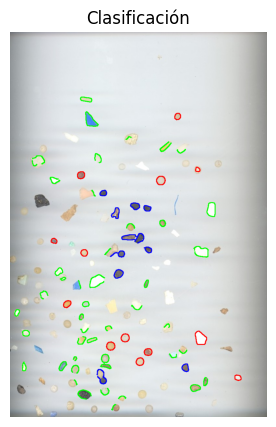

In [58]:
def clasificar_contornos(contornos, img_gris, img_rgb):
    # Inicializar los contadores para cada tipo
    fragmentos, pellets, alquitran = 0, 0, 0
    
    # Recorrer contornos
    for contorno in contornos:
        # Calcular el área y el perímetro del contorno
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        if area == 0:  # Evitar división entre cero
            continue
        
        # Calcular el rectángulo delimitador y el círculo envolvente mínimo para característica geométrica
        _, _, w, h = cv2.boundingRect(contorno)
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)
        
        # Características geométricas
        relacion_aspecto = w / h if h != 0 else 0   # compara ancho y alto de rectángulo, si es cercano a 1 es más cuadrado que circular
        compacidad = (perimetro ** 2) / area        # si la compacidad es baja es un fragmento con forma regular
        circularidad = 4 * np.pi * (area / (perimetro ** 2))  # si es cercano a 1 es circular
        
        # Color medio dentro del contorno (intensidad de gris para detectar alquitrán)
        mascara = np.zeros_like(img_gris)                   # Crea una máscara negra
        cv2.drawContours(mascara, [contorno], -1, 255, -1)  # Dibujar el contorno e inteiror como máscara blanca
        color_medio = cv2.mean(img_gris, mask=mascara)[0]   # Promedio del color dentro del contorno

        mask_alquitran = cv2.inRange(img_gris, 80, 100)                # Definimos el rango de valores de gris oscuro para alquitrán
        contorno_alquitran = cv2.bitwise_and(mascara, mask_alquitran)  # Máscara con el rango de gris oscuro

        if np.count_nonzero(contorno_alquitran) > 0:                   # Si el contorno es de rango gris oscuro, es alquitrán
            alquitran += 1                              
            cv2.drawContours(img_rgb, [contorno], -1, (0, 0, 255), 2)  # Contorno azul
        elif circularidad > 0.8 and 0.8 < relacion_aspecto < 1.2:      # si es circular u ovalado, es pellet
            pellets += 1
            cv2.drawContours(img_rgb, [contorno], -1, (255, 0, 0), 2)  #Contorno rojo
        else:                                                          # si no cumple nada de lo anterior, es fragmento
            fragmentos += 1
            cv2.drawContours(img_rgb, [contorno], -1, (0, 255, 0), 2)  # Contorno verde
    
    return fragmentos, pellets, alquitran

# Clasificar los contornos
fragmentos, pellets, alquitran = clasificar_contornos(contornos, img_gris, img_rgb)

# Imprime la cantidad de cada tipo
print(f"Fragmentos: {fragmentos}, Pellets: {pellets}, Alquitran: {alquitran}")

# Mostrar imagen con contornos clasificados
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(img_rgb)
plt.title("Clasificación")
plt.show()

Accuracy (TP/(n))= 0.775
Precision (TP/(TP+FP)) = 0.8376288659793815
Recall (TP/(TP+FN)) = 0.775
F1 Score (2*(precision*recall)/(precision+recall)) = 0.7358773019997741


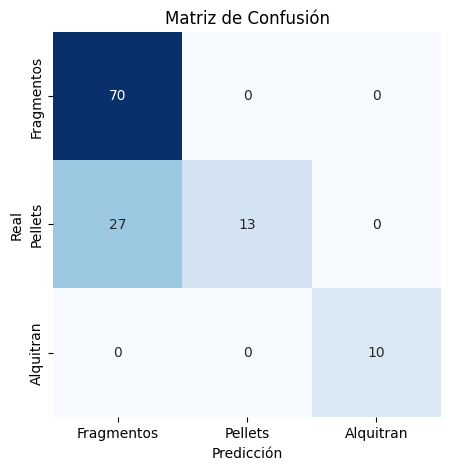

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Valores reales
# Alquitran: 10, Pellets: 40, Fragmentos: 70
y_real = np.array([2] * 10 + [1] * 40 + [0] * 70)  # 0 = Fragmentos, 1 = Pellets, 2 = Alquitran

# Valores predichos
# Alquitran: 10, Pellets: 13, Fragmentos: 45
y_pred = np.array([2] * 10 + [1] * 13 + [0] * 45 + [0] * (120 - 68))  # Asegurar que haya 120 elementos en total

# Cálculo de métricas
accuracy = accuracy_score(y_real, y_pred)
precision = precision_score(y_real, y_pred,average='weighted')
recall = recall_score(y_real, y_pred,average='weighted')
f1score = f1_score(y_real, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

matriz_confusion = confusion_matrix(y_real, y_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Fragmentos', 'Pellets', 'Alquitran'], yticklabels=['Fragmentos', 'Pellets', 'Alquitran'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()